# Fitting a Straight Line

For a first tutorial we're going to tackle one of the best-known problems: fitting a straight line to data. Fitting a straight line in this way is not particularly efficient, but it will help us get acquainted with `chromatic_fitting` in a way that we're probably already familiar with.

We will first import `chromatic_fitting`, `chromatic` (which our package is based on), a distribution from `pymc3`, and a few other handy packages.

In [1]:
from chromatic_fitting import *
from pymc3 import Uniform
import numpy as np
import matplotlib.pyplot as plt

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.6.1!

This program is running on:
Python v3.9.12 (main, Apr  5 2022, 01:52:34) 
[Clang 12.0.0 ]
numpy v1.21.5
chromatic v0.4.2
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


## Make some data

First we need to make some data. We can generate a straight line and add some random noise:

In [2]:
size = 100
true_intercept = 0.9
true_slope = 0.4
true_noise = 0.07

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + (true_slope * x)
# add noise
y = true_regression_line + np.random.normal(scale=true_noise, size=size)
yerr = [true_noise] * len(x)

Let's have a look at our noisy line:

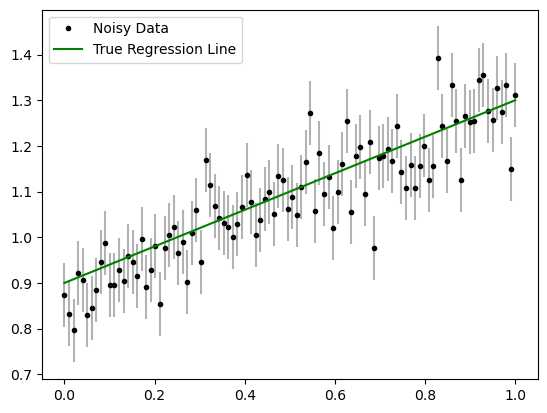

In [3]:
plt.plot(x,y,'k.', label='Noisy Data')
plt.errorbar(x,y,yerr,linestyle='None',color='k',alpha=0.3)
plt.plot(x,true_regression_line,color='g',label='True Regression Line')
plt.legend();

Looks good! Now we need to turn this noisy line data into something that `chromatic_fitting` will understand. `chromatic_fitting` is built on top of `chromatic` and uses objects called [`Rainbows`](https://zkbt.github.io/chromatic/basics/) 🌈. For more information about `Rainbows` please see the great `chromatic` docs [here](https://zkbt.github.io/chromatic/). In this case we will create a `Rainbow` object with `x` as our time axis and one (arbitrary) wavelength, then plug in our `flux` (`y`) and `uncertainty` (`yerr`) values:

In [4]:
# create simulated rainbow
r = SimulatedRainbow(time=x * u.day, wavelength=[1] * u.micron)
r.fluxlike['flux'] = np.array([y] * r.nwave)
r.fluxlike['uncertainty'] = np.array([yerr] * r.nwave)
r.fluxlike['model'] = np.array([true_regression_line]*r.nwave)

r

<Simulated🌈(1w, 100t)>

Let's see our `Rainbow` and check it looks like our noisy line above! By default `Rainbow` objects are 3-D representing flux as a function of wavelength and time, so the visualizations are mostly in 3-D (as below):

🌈🤖 The wavelength scale for this rainbow is 'linear',
and there are 1 wavelength centers and
0 wavelength edges defined.

It's hard to imshow something with a wavelength axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its wavelength edges defined. We're giving up
and just using the wavelength index as the wavelength axis.

If you want a real wavelength axis, one solution would
be to bin your wavelengths to a more uniform grid with
`rainbow.bin(R=...)` (for logarithmic wavelengths) or
`rainbow.bin(dw=...)` (for linear wavelengths)



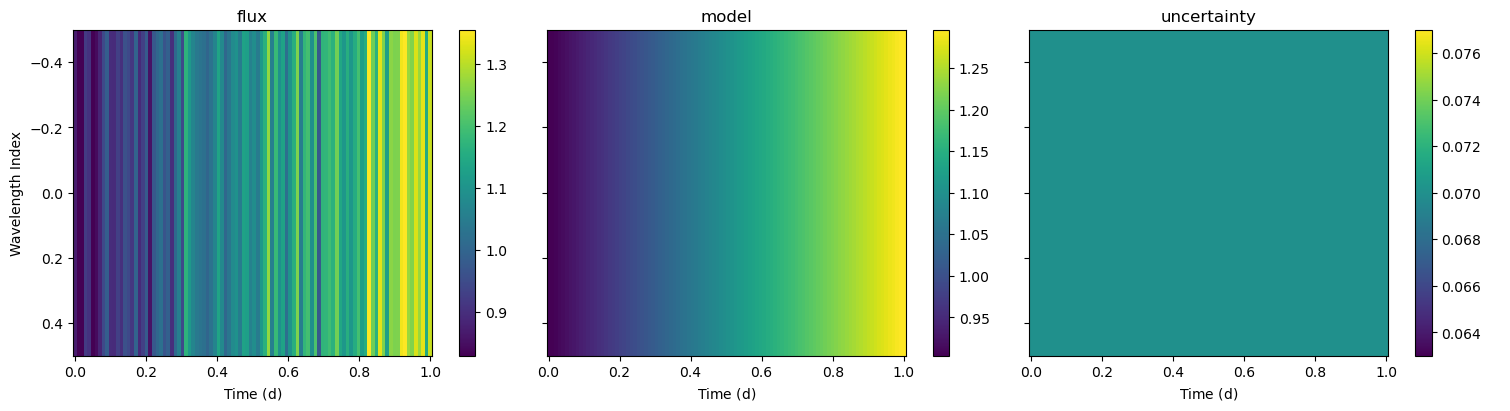

In [5]:
# plot our Rainbow:
r.imshow_quantities();

In [6]:
r.fluxlike.keys()

dict_keys(['flux', 'model', 'uncertainty'])

But if we want to see our data in 2-D again then we just have to say `.plot_lightcurves()` and we're back where we started...

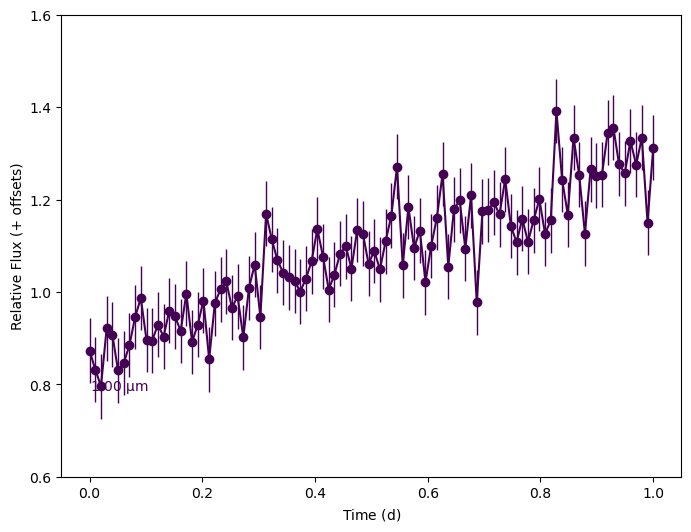

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
r.plot_lightcurves(ax=ax)
plt.ylim(0.6,1.6);

## Create a PolynomialModel

Now onto `chromatic_fitting`! `chromatic_fitting` works by using a class of model that defines the parameters we need and a function we would like to fit. For a straight line we want to use `PolynomialModel`. This model can be used to model any type of polynomial function (e.g. $y=x^2$ or $y=1+2x+5x^7$), but at its simplest it can model a constant value or a straight line. To set up a `PolynomialModel` we just need to tell it the maximum degree we would like to model. For a straight line that would be 1.

In [8]:
# create polynomial model:
l = PolynomialModel(degree=1, name='linear_tutorial')
l

<chromatic polynomial model 'linear_tutorial' 🌈>

Each model will have some necessary parameters to run. For a `PolynomialModel` the only parameter you need is a constant term. Otherwise we'd have nothing to fit!

In [9]:
l.required_parameters

['p_0']

Every coefficient term will default to 0.0 unless we assign it a value. For example if we defined a `PolynomialModel` of `degree` = 2 we could model the equation $y=4+3x^2$ by defining $p_0=4$ and $p_2=3$.

In [10]:
l.defaults

{'p_0': 0.0, 'p_1': 0.0}

Now we want to tell the model what function we want to model and what our prior distributions are for each parameter. Since we only have one wavelength in this example we don't need to worry about `WavelikeFitted` parameters here, we can just use `Fitted`. See [this tutorial](https://catrionamurray.github.io/chromatic_fitting/parameters/) for an intro to `Parameters`:

In [11]:
# set up polynomial model parameters:
l.setup_parameters(
    p_0 = Fitted(Uniform, testval=0.8, upper=2, lower=0),
    p_1 = Fitted(Uniform,testval=0.1,upper=1,lower=0)
)

# print a summary of all params:
l.summarize_parameters()

linear_tutorial_p_0 =
  <🧮 Fitted Uniform(testval=0.8, upper=2, lower=0, name='linear_tutorial_p_0') 🧮>

linear_tutorial_p_1 =
  <🧮 Fitted Uniform(testval=0.1, upper=1, lower=0, name='linear_tutorial_p_1') 🧮>



All we've done here is to tell the model we want have Uniform distributions for $p_0$ and $p_1$ (or y-intercept and gradient) of $\mathcal{U}(0,2)$ and $\mathcal{U}(0,1)$ with initial test values of 0.8 and 0.1 respectively.

Now we can attach the `Rainbow` to our model and set it up before we perform our fit!

In [12]:
# setup model the same way as for the transit model!:
l.attach_data(r)
l.setup_lightcurves(store_models=True)
l.setup_likelihood()

**NOTE:** The polynomial model can fit to a normalized array (using `normalize=True`). This normalization step is $x_n=\frac{x-mean(x)}{std(x)}$. This won't affect our final model but this means the parameters $p_1, p_2, p_3 ...$ will have to be converted back into the correct form to compare to the original array! E.g. in our case ($y=mx+c$) if we normalize the time axis then we will need to do the transforms $m$ ->  $m/std(x)$ and $c$ -> $c-(m * mean(x)/std(x))$ at the end. This will get significanlty more complicated the higher in order we go so it's best to not normalize by default.

Let's see what our PyMC3 model looks like at this stage:

In [13]:
l._pymc3_model

We should have 2 parameter distributions and one `data` distribution here. This distribution tells us that we are fitting our data (`r`) to the model assuming Gaussian errors (`r.uncertainty`). We can ignore the `_interval__` parameters - these are internal to PyMC3 and we should never have to worry about these.

If we want to take a sneak peek at our "guesses" for the best-fit model using samples from our prior distributions, we can plot the priors:

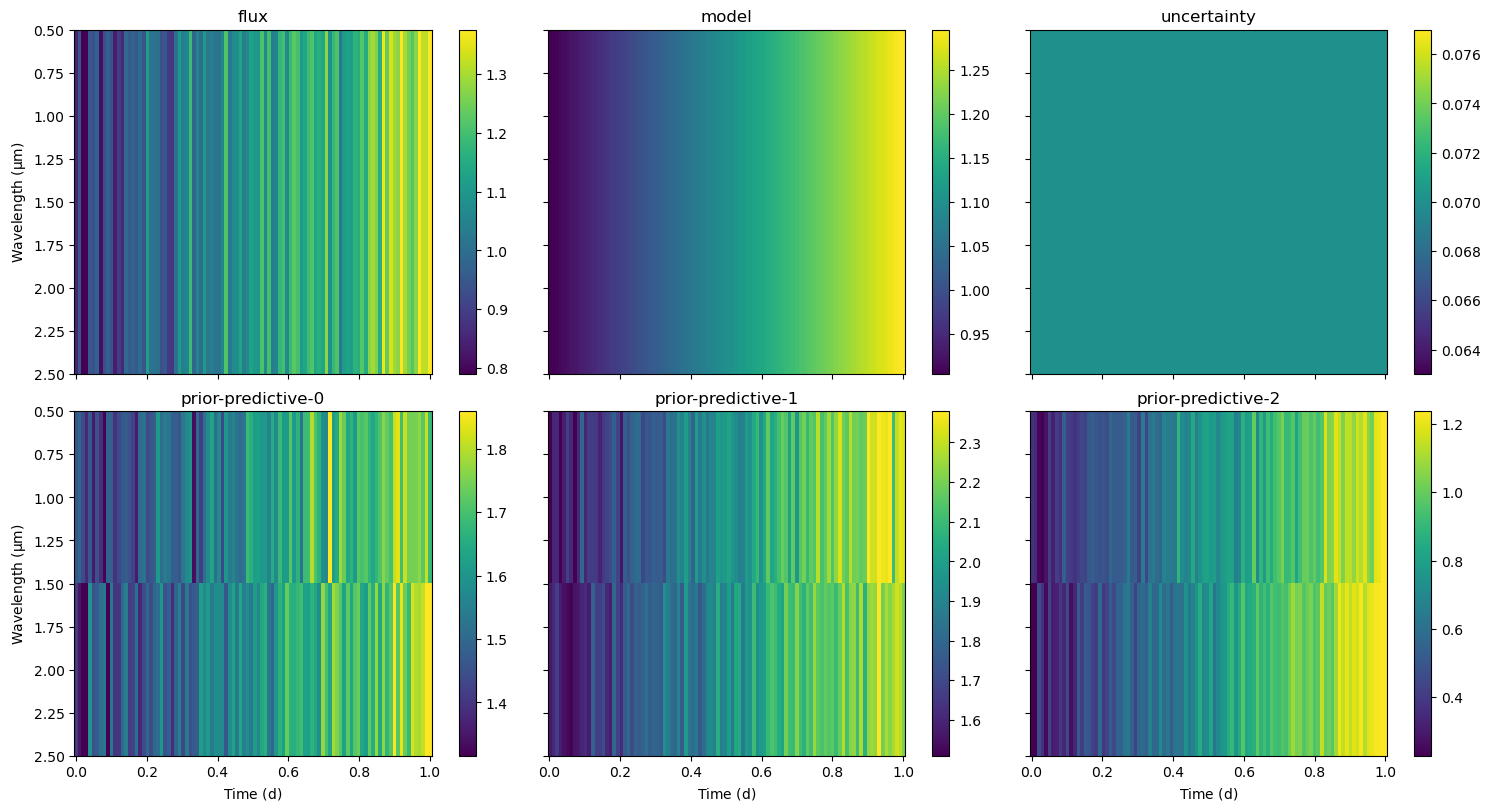

In [14]:
l.plot_priors(n=3)

By checking the priors we can make sure we're not using priors that are vastly off or too tight!

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling!

In [15]:
# optimize for initial values!
opt = l.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
l.sample(start=opt, tune=300, draws=300, chains=4, cores=4)

optimizing logp for variables: [linear_tutorial_p_1, linear_tutorial_p_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -1159.4766618162366 -> 259.83086871136305


/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Only 300 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [linear_tutorial_p_1, linear_tutorial_p_0]


Sampling 4 chains for 300 tune and 300 draw iterations (1_200 + 1_200 draws total) took 1 seconds.


In this example it should be very quick as we are only fitting 2 parameters! Now we can look at our results:

In [16]:
l.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                                  mean        sd   hdi_16%   hdi_84%  \
linear_tutorial_p_0[0]        0.882356  0.010058  0.872048  0.891082   
linear_tutorial_p_1[0]        0.426598  0.017024  0.410510  0.443404   
linear_tutorial_model[0, 0]   0.882356  0.010058  0.872048  0.891082   
linear_tutorial_model[0, 1]   0.886665  0.009910  0.876623  0.895442   
linear_tutorial_model[0, 2]   0.890974  0.009762  0.881245  0.899787   
...                                ...       ...       ...       ...   
linear_tutorial_model[1, 95]  1.291717  0.009151  1.283942  1.302008   
linear_tutorial_model[1, 96]  1.296026  0.009295  1.288271  1.306608   
linear_tutorial_model[1, 97]  1.300336  0.009440  1.289833  1.308483   
linear_tutorial_model[1, 98]  1.304645  0.009586  1.294073  1.312976   
linear_tutorial_model[1, 99]  1.308954  0.009732  1.297977  1.317213   

                              mcse_mean   mcse_sd    ess_bulk    ess_tail  \
linear_tutorial_p_0[0]         0.000345  0.000244  870.134

An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical, therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

We can turn this summary table into something more useful by calling `.get_results()`. For one wavelength it won't look much better but the more wavelengths we fit the more confusing this summary table will get.

In [17]:
l.get_results(uncertainty=['hdi_16%','hdi_84%'])

,linear_tutorial_p_0,linear_tutorial_p_0_hdi_16%,linear_tutorial_p_0_hdi_84%,linear_tutorial_p_1,linear_tutorial_p_1_hdi_16%,linear_tutorial_p_1_hdi_84%,wavelength
w0,0.882356,0.872048,0.891082,0.426598,0.41051,0.443404,1.0 micron
w1,0.882356,0.872048,0.891082,0.426598,0.41051,0.443404,2.0 micron


Say we also want to see the "best-fit" model directly, we can use the `.get_model()` function:

In [18]:
model = l.get_model()
model.keys()

dict_keys(['w0', 'w1'])

Remember that lightcurve we plotted earlier? Once we have fit a model the "best-fit" should show up on there automatically:

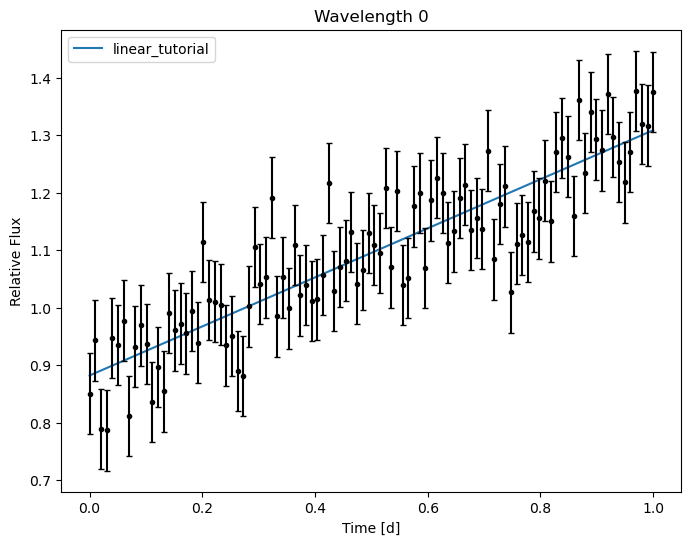

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
l.plot_model(ax=[ax])

In [20]:
var_names = {**l.trace[0],**{"data":[]}}.keys() #.sample_posterior(3)
# l.plot_posteriors()

In [31]:
np.shape(l.sample_posterior(ndraws=3, var_names=var_names)['linear_tutorial_model'][0])

(2, 100)

/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


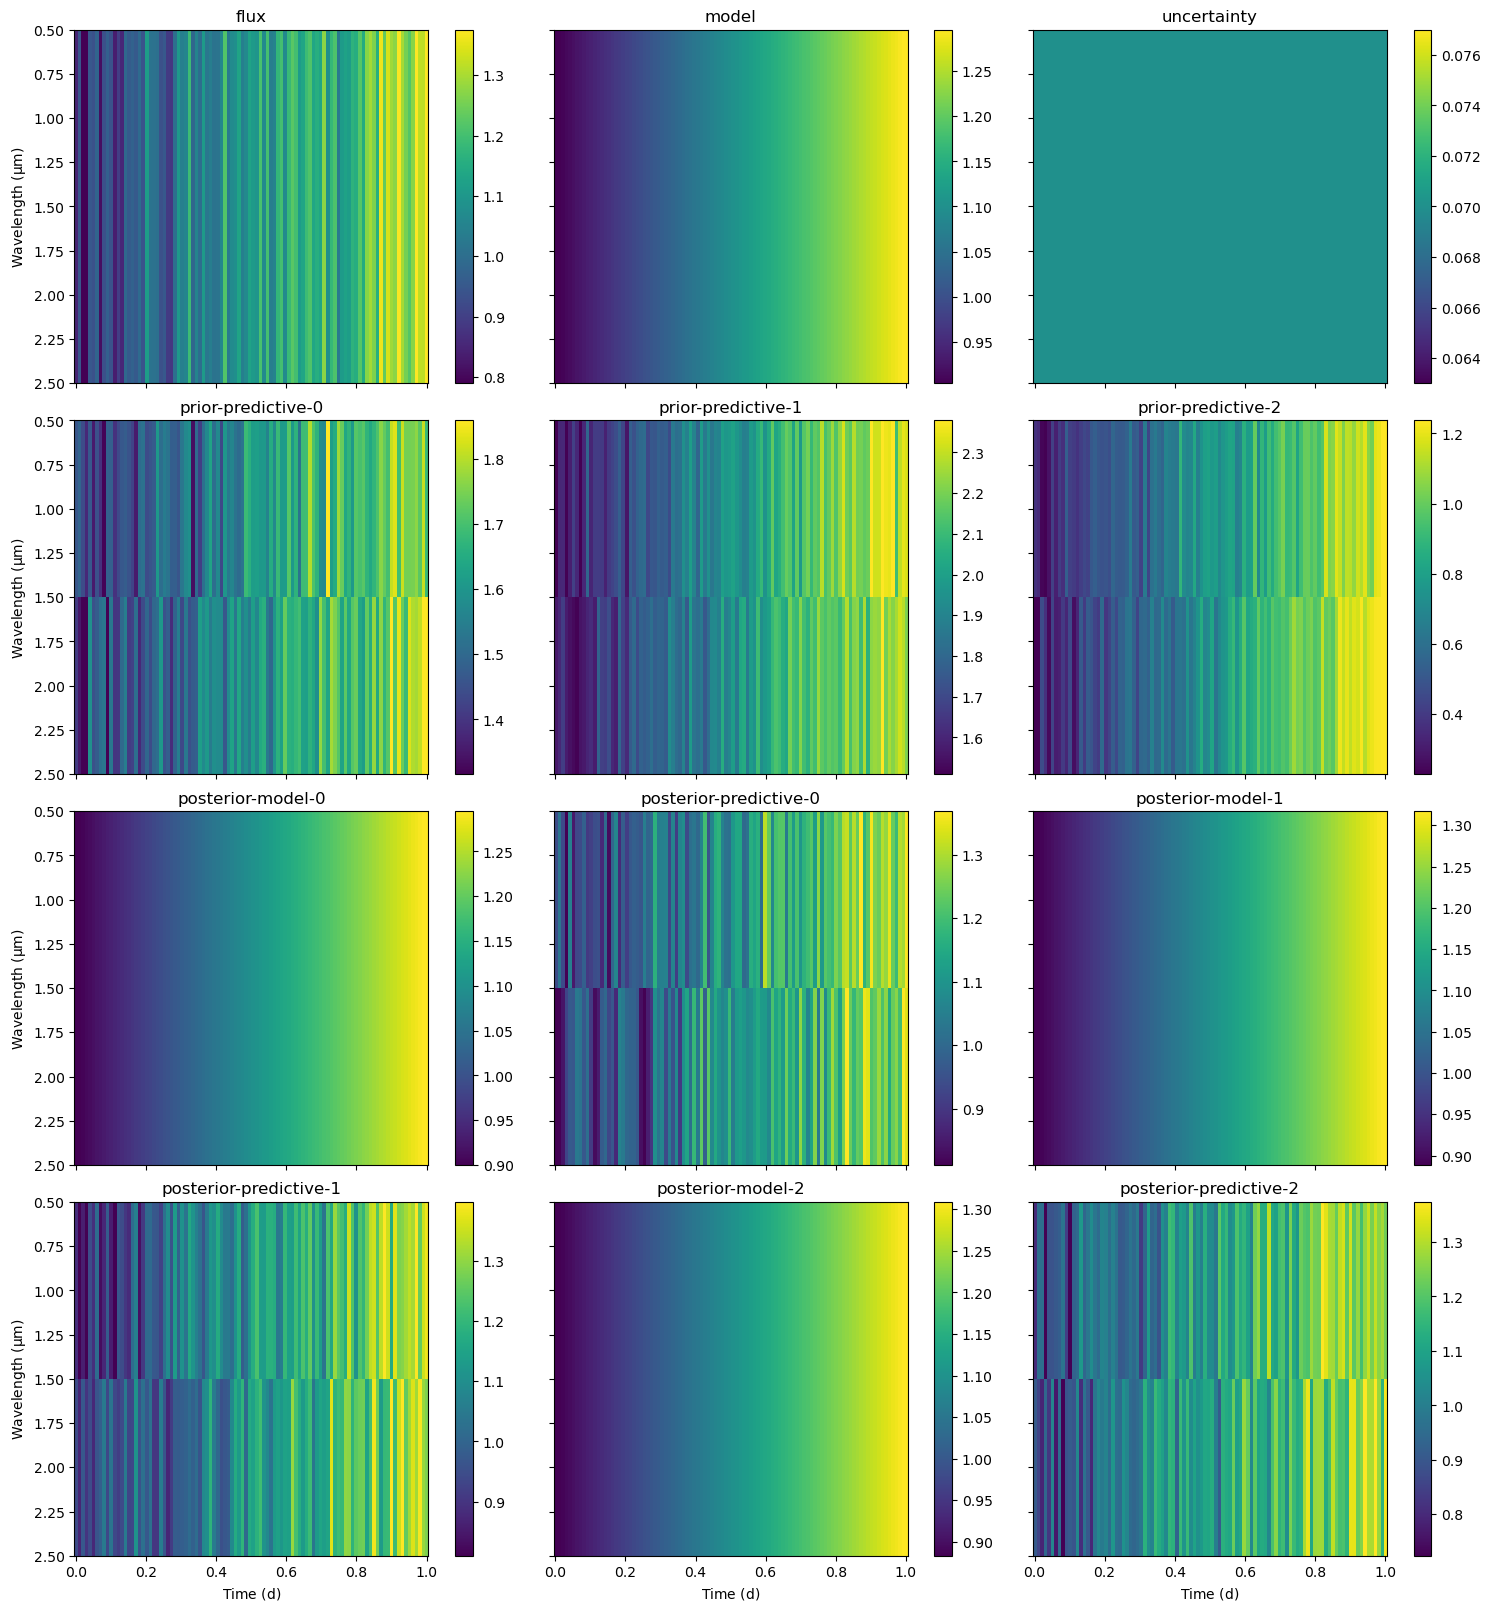

In [21]:
l.plot_posteriors()

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


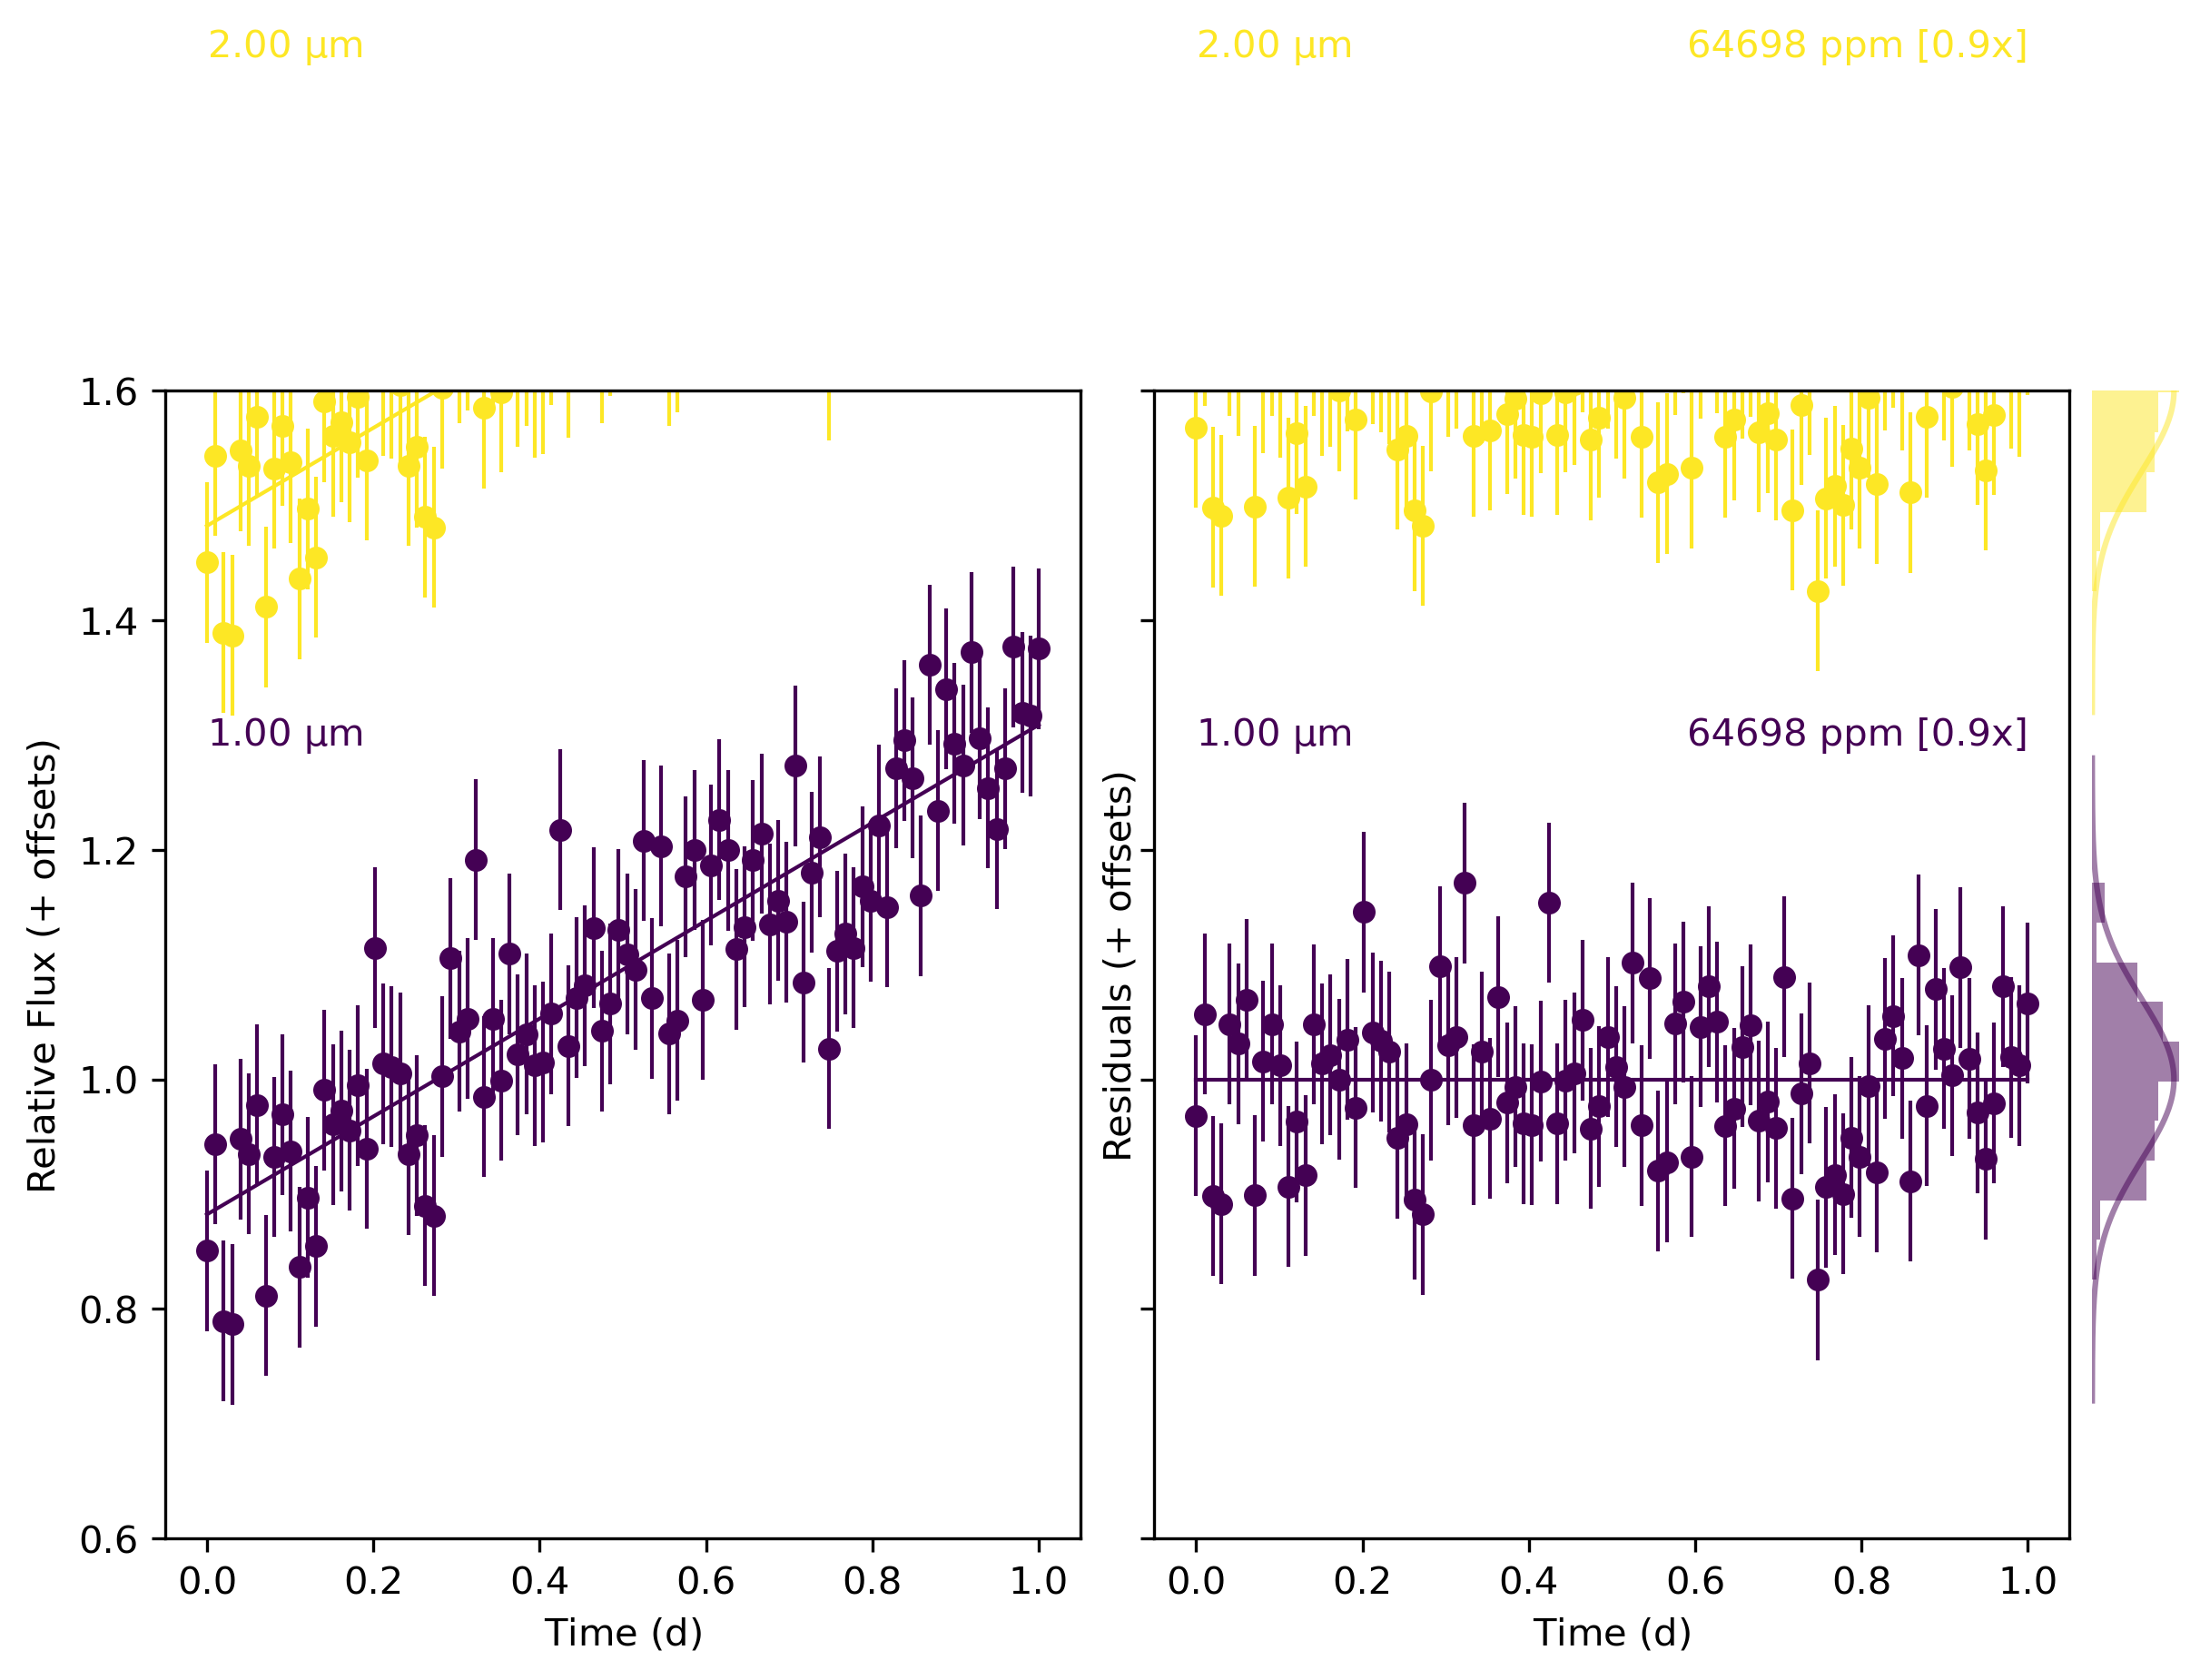

In [22]:
l.plot_with_model_and_residuals(spacing=-.6)
plt.ylim(0.6,1.6);

🌈🤖 'planet_model' doesn't exist and will be skipped.



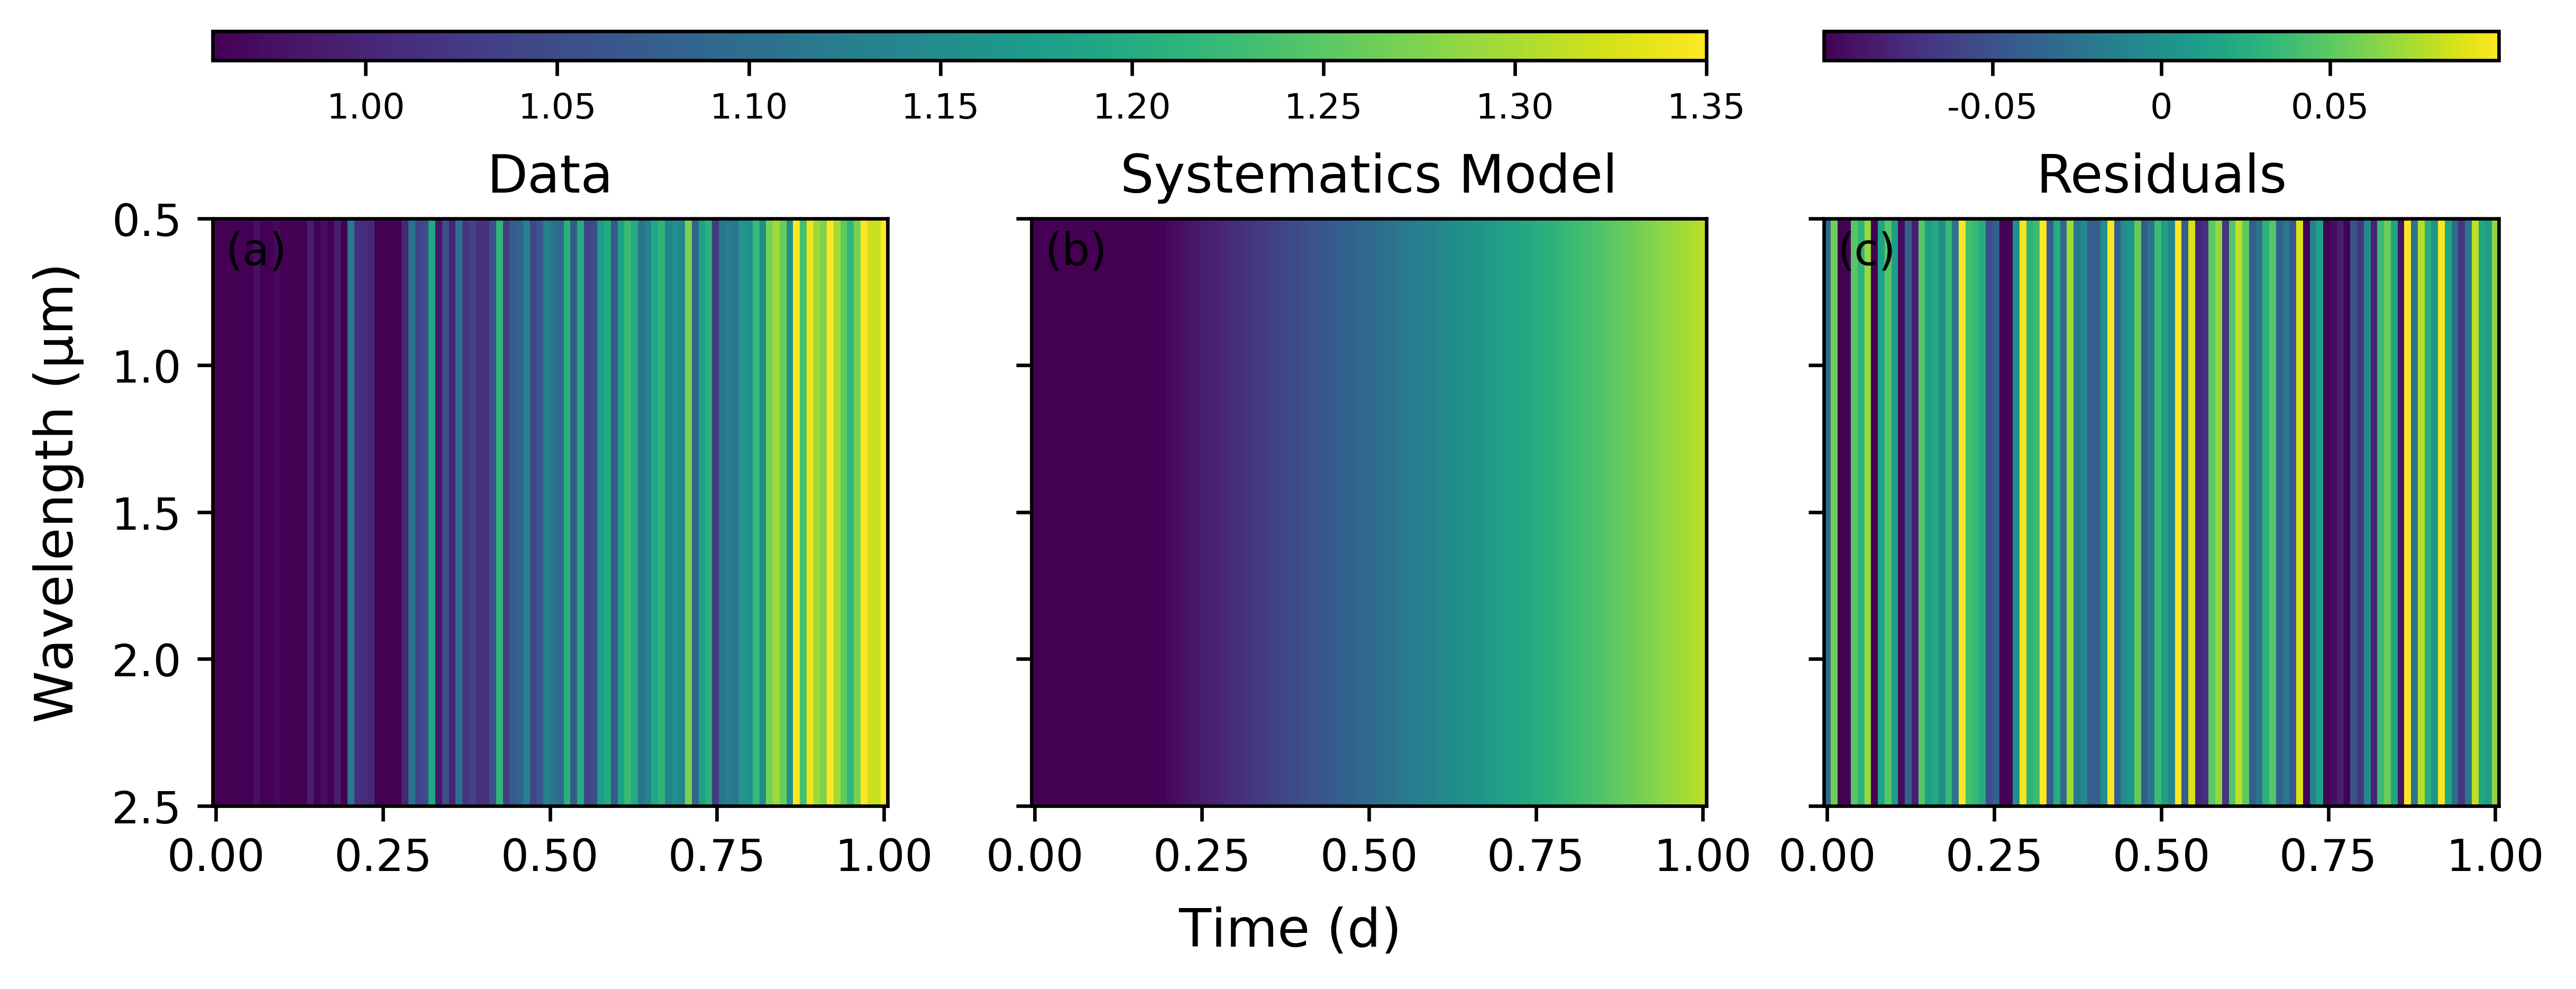

In [23]:
l.imshow_with_models(vlimits_data=[0.96, 1.35], vspan_residuals=0.1)

## Compare Results to True Line 

Since we know exactly what we injected into the data set we can compare our results to the "true" value:

In [24]:
fitted_intercept = l.summary['mean'][f'{l.name}_p_0[0]']
fitted_intercept_err = l.summary['sd'][f'{l.name}_p_0[0]']
fitted_gradient = l.summary['mean'][f'{l.name}_p_1[0]']
fitted_gradient_err = l.summary['sd'][f'{l.name}_p_0[0]']

print(f"Fitted y-intercept = {fitted_intercept} +/- {fitted_intercept_err}, true value = {true_intercept}")
print(f"Fitted gradient = {fitted_gradient} +/- {fitted_gradient_err}, true value = {true_slope}")

Fitted y-intercept = 0.8823556 +/- 0.0100584, true value = 0.9
Fitted gradient = 0.4265982 +/- 0.0100584, true value = 0.4


Hopefully, if everything's worked then these values should agree within error!

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

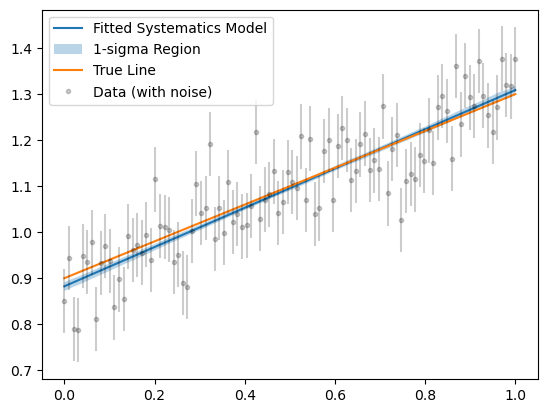

In [25]:
# plot the fitted model
plt.plot(l.data.time, l.data_with_model.systematics_model[0], label='Fitted Systematics Model')

# ONLY UNCOMMENT IF YOU STORED MODELS EARLIER:
lower_hdi=[l.summary['hdi_16%'][f'linear_tutorial_model[0, {i}]'] for i in range(l.data.ntime)]
upper_hdi=[l.summary['hdi_84%'][f'linear_tutorial_model[0, {i}]'] for i in range(l.data.ntime)]
plt.fill_between(l.data.time.to_value('d'), lower_hdi, upper_hdi, alpha=0.3, label='1-sigma Region')

# plot the injected line
plt.plot(x, true_regression_line, label='True Line')

# plot the data we fit
plt.plot(l.data.time, l.data.flux[0,:], "k.", alpha=0.2, label='Data (with noise)')
plt.errorbar(l.data.time, l.data.flux[0,:], l.data.uncertainty[0,:], color='k', linestyle="None", alpha=0.2)

plt.legend();

Hopefully our results should look pretty close to the real values! Now we can move onto something a little more challenging...